In [1]:
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
from skimage.segmentation import mark_boundaries


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


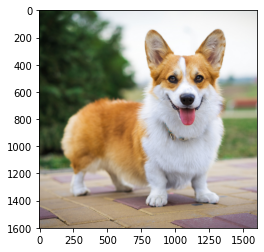

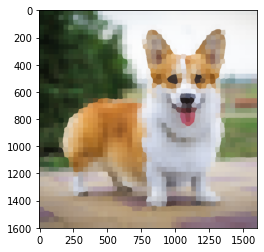

In [2]:
img = plt.imread('corgi-dog.jpg')
img2 = plt.imread('corgi-dog.jpg')
num_seg = 2000
plt.figure()
plt.imshow(img)
segments_slic = slic(img, n_segments=num_seg, compactness=100, channel_axis=2)
plt.figure()
plt.imshow(mark_boundaries(img, segments_slic, color=(255, 0, 0)))
for seg_no in range(num_seg):
    seg_pxs = tuple(np.argwhere(segments_slic == seg_no).T.tolist())
    img[seg_pxs] = np.ma.average(img[seg_pxs], axis=0)
    
plt.imshow(img)


For the given 250 segments and 10 compactness, the superpixels captured most of the general image of the corgi properly, but smaller details such as the eyes were missing. Because the shape of the superpixels seemed to be alright for the image, I decided to increase the number of segments to try to recover some more of the finer details. Increasing the segments to 2000 and leaving the compactness at 10 delivered pretty good "coarse" results. Further increasing the segments to 5000 lead to a better "fine" result, which sharpened up the details a bit. The SLIC method reminds of a gaussian blur, but with "borders" for the blurring.

Based off of the API for skimage.slic, I read that the compactness controls how similar in shape to a rectangular pixel the segments are, and should be tested in a logarithimic way. Therefore, I then tested values of 1 and 100 for the compactness. At 100, the rectangular shape of the segments was pretty noticeable, and the image looked more like a very low resolution version of the original image. 

/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/evanhuang/.virtualenvs/cse5524/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/7l/y25jb2qn2k5_pcq133b7j7900

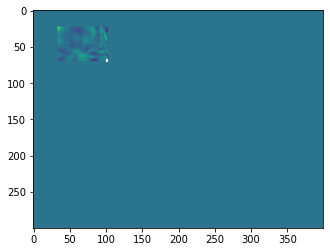

In [3]:
def ncc(patch, tgt):
    ncc_val = np.zeros(3)
    for color in range(2):
        color_patch = patch[:, :, color]
        color_tgt = tgt[:, :, color]
        p_avg = np.average(color_patch)
        t_avg = np.average(color_tgt)
        p_std = np.std(color_patch)
        t_std = np.std(color_tgt)
        for r, c in np.ndindex(color_patch.shape):
            ncc_val[color] += (color_patch[r, c] - p_avg) * \
                (color_tgt[r, c] - t_avg) / p_std * t_std
    return np.sum(ncc_val / (patch.size - 1))


template = plt.imread('template.png')
search = plt.imread('search.png')

offset_r = math.floor(template.shape[0]/2)
offset_c = math.floor(template.shape[1]/2)
limits_r = offset_r, search.shape[0] - offset_r
limits_c = offset_c, search.shape[1] - offset_c
regions = [template[r-offset_r:r+offset_r, c-offset_c:c+offset_c, :]
           for r in range(*limits_r)
           for c in range(*limits_c)]

match_dist = np.zeros((search.shape[0]-template.shape[0],
                       search.shape[1]-template.shape[1]))
match_dist = np.zeros((search.shape[0], search.shape[1]))
i = 0
for r in range(*limits_r):
    for c in range(*limits_c):
        match_dist[r, c] = ncc(regions[i], template)
        i += 1
plt.imshow(match_dist)

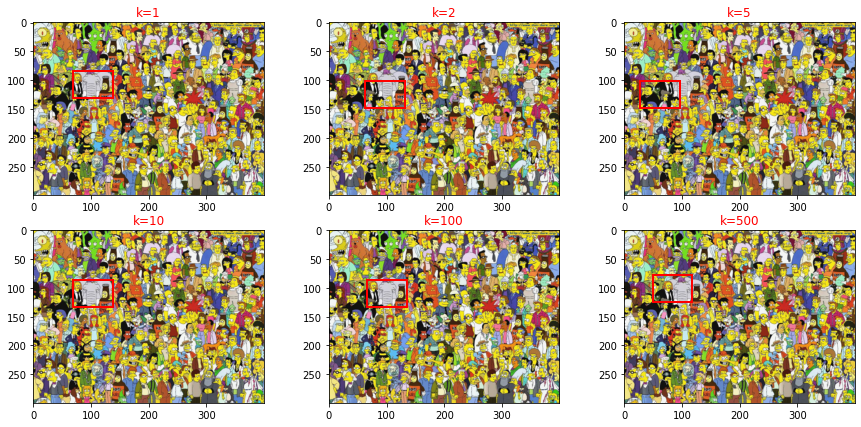

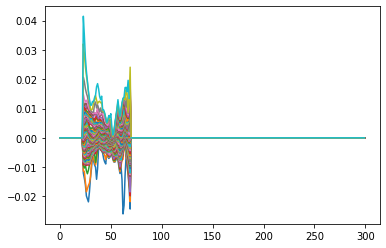

In [4]:
def show_kth_matches(img, *args):
    plt.figure(figsize=(15,7))
    sub = 1
    for i in args:
        plt.subplot(2, 3, sub)
        plt.imshow(img)
        ax = plt.gca()
        ax.imshow(img)
        i_min = np.unravel_index(np.argpartition(
            match_dist, i, axis=None)[i], match_dist.shape)
        # print(C[temp])
        # print(match_dist[i_min])
        # print(i_min)
        x = i_min[0]
        y = i_min[1]
        rect = patches.Rectangle(
            (x, y), 69, 47, linewidth=2, edgecolor='r', facecolor="none", zorder=100)
        ax.add_patch(rect)
        plt.gca().set_title(f'k={i}', c='r')
        sub += 1
    plt.show()

show_kth_matches(search, 1, 2, 5, 10, 100, 500)

plt.figure()
plt.plot(np.sort(match_dist))
plt.show()

The highest match was essentially a perfect outline of the template image. Also interesting was the k=2/k=5 vs the k=10/k=100 matches. I would have expected that the lower k's would be pretty similar to the k=1, but I was wrong. As can be seen in the graph, there is a second peak that affects the distribution of k's close to the max k. This goes away with the higher k's and once again the correct template region is displayed by k=10 and k=100. 